# Watch a temperature : scan temperature *v* time

From *APS Python Training for Bluesky Data Acquisition*.

**Objective**

Measure the temperature for a short period and compute basics measures of the collected readings.

## Start the `instrument` package

Our instrument package is in the `bluesky` subdirectory here so we add that to the search path before importing it.

In [1]:
import pathlib, sys
sys.path.append(str(pathlib.Path.home() / "bluesky"))
from instrument.collection import *

/home/prjemian/bluesky/instrument/_iconfig.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/docs/source/howto/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Thu-17:54:44 - ############################################################ startup
I Thu-17:54:44 - logging started
I Thu-17:54:44 - logging level = 10
I Thu-17:54:44 - /home/prjemian/bluesky/instrument/session_logs.py
I Thu-17:54:44 - /home/prjemian/bluesky/instrument/collection.py
I Thu-17:54:44 - CONDA_PREFIX = /home/prjemian/.conda/envs/bluesky_2023_2


Exception reporting mode: Minimal


I Thu-17:54:44 - xmode exception level: 'Minimal'
I Thu-17:54:44 - /home/prjemian/bluesky/instrument/mpl/notebook.py
I Thu-17:54:44 - #### Bluesky Framework ####
I Thu-17:54:44 - /home/prjemian/bluesky/instrument/framework/check_python.py
I Thu-17:54:44 - /home/prjemian/bluesky/instrument/framework/check_bluesky.py
I Thu-17:54:44 - /home/prjemian/bluesky/instrument/framework/initialize.py
I Thu-17:54:44 - RunEngine metadata saved in directory: /home/prjemian/Bluesky_RunEngine_md
I Thu-17:54:44 - using databroker catalog 'training'
I Thu-17:54:44 - using ophyd control layer: pyepics
I Thu-17:54:44 - /home/prjemian/bluesky/instrument/framework/metadata.py
I Thu-17:54:44 - /home/prjemian/bluesky/instrument/epics_signal_config.py
I Thu-17:54:44 - Using RunEngine metadata for scan_id
I Thu-17:54:44 - #### Devices ####
I Thu-17:54:44 - /home/prjemian/bluesky/instrument/devices/area_detector.py
I Thu-17:54:44 - /home/prjemian/bluesky/instrument/devices/calculation_records.py
I Thu-17:54:47 - 

## Describe

Note the initial settings of the `temperature` (controller).  It's actually an EPICS *swait* record that simulates a temperature sensor and controller.  It has a setpoint, a readback, and a few other support attributes as shown.  A Random noise level is part of the simulation.  We'll compute that noise level from the standard deviation of the measurements.

In [2]:
listdevice(temperature)

=============================== =================================== ==========================
data name                       value                               timestamp                 
=============================== =================================== ==========================
temperature_setpoint            25.0                                2023-04-13 17:54:49.157724
temperature                     0.0                                 2023-04-13 17:54:49.159466
temperature_done                False                               2023-04-13 17:54:49.178146
temperature_calculation         A+max(-D,min(D,(B-A)))+C*(RNDM-0.5) 2023-04-13 17:54:49.160429
temperature_description         temperature                         2023-04-13 17:54:49.154181
temperature_max_change          2.0                                 2023-04-13 17:54:49.160349
temperature_noise               1.0                                 2023-04-13 17:54:49.159466
temperature_previous_value_pv   gp:userCalc8.VAL  

## Count
Use the bluesky RunEngine, `RE`, and a standard plan, `bp.count()`, to _count_ the temperature.  The `bp.count()` plan triggers (typically a scaler) and then reads from the detector.  In this case, the `temperature` device's `.trigger()` method does not do anything, yet it is still _countable_.

In [3]:
RE(bp.count([temperature]))



Transient Scan ID: 958     Time: 2023-04-13 17:54:49
Persistent Unique Scan ID: 'cd24d583-6fd9-43ce-9ea3-583b104c2a6d'
New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+-------------+
|   seq_num |       time | temperature |
+-----------+------------+-------------+
|         1 | 17:54:49.4 |     0.00000 |
+-----------+------------+-------------+
generator count ['cd24d583'] (scan num: 958)


('cd24d583-6fd9-43ce-9ea3-583b104c2a6d',)

Take ten readings by adding the `num=10` keyword argument (a.k.a. *kwarg*).



Transient Scan ID: 959     Time: 2023-04-13 17:54:49
Persistent Unique Scan ID: '8b99ba9a-1361-4b5d-8910-3a7b1e0566e2'
New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+-------------+
|   seq_num |       time | temperature |
+-----------+------------+-------------+
|         1 | 17:54:49.8 |     0.00000 |
|         2 | 17:54:49.8 |     0.00000 |
|         3 | 17:54:49.8 |     0.00000 |
|         4 | 17:54:49.9 |     2.24478 |
|         5 | 17:54:49.9 |     2.24478 |
|         6 | 17:54:49.9 |     2.24478 |
|         7 | 17:54:50.0 |     2.24478 |
|         8 | 17:54:50.0 |     2.24478 |
|         9 | 17:54:50.0 |     2.24478 |
|        10 | 17:54:50.0 |     2.24478 |
+-----------+------------+-------------+
generator count ['8b99ba9a'] (scan num: 959)


('8b99ba9a-1361-4b5d-8910-3a7b1e0566e2',)

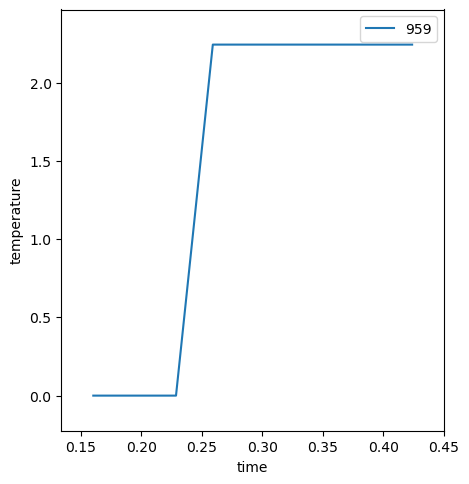

In [4]:
RE(bp.count([temperature], num=10))

Do all the readings look the same?  Perhaps there are only two different values (first one, then the other)?  That's because our measurements were only *reading* the temperature without waiting for it to update.  (If there are two different values, we caught the moment when EPICS updated the calculation.)  The table above showed `temperature_scanning_rate 5` which means EPICS is only updating every 2 seconds.

In [5]:
temperature.scanning_rate.get(as_string=True)

'2 second'

## Adjust the measurement interval
We need to slow down the measurement to this interval by adding the `delay=2` kwarg, sampling every 2 seconds.



Transient Scan ID: 960     Time: 2023-04-13 17:54:50
Persistent Unique Scan ID: 'b55776f1-0a02-464c-9762-fe807c90c014'
New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+-------------+
|   seq_num |       time | temperature |
+-----------+------------+-------------+
|         1 | 17:54:50.6 |     2.24478 |
|         2 | 17:54:52.6 |     4.66694 |
|         3 | 17:54:54.6 |     6.66461 |
|         4 | 17:54:56.6 |     8.64790 |
|         5 | 17:54:58.6 |    10.99491 |
|         6 | 17:55:00.6 |    13.23049 |
|         7 | 17:55:02.6 |    15.09944 |
|         8 | 17:55:04.6 |    17.26870 |
|         9 | 17:55:06.6 |    19.20524 |
|        10 | 17:55:08.6 |    21.33919 |
+-----------+------------+-------------+
generator count ['b55776f1'] (scan num: 960)


('b55776f1-0a02-464c-9762-fe807c90c014',)

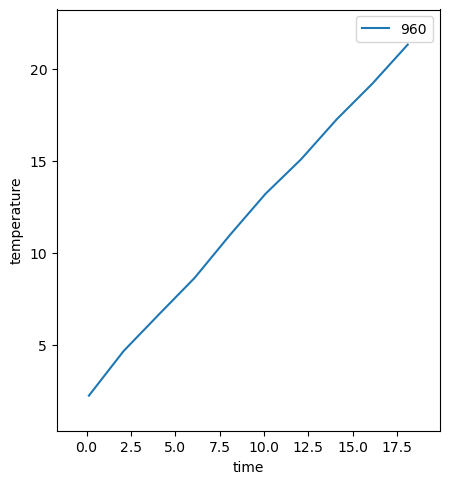

In [6]:
RE(bp.count([temperature], num=10, delay=2))

Let's reduce the update interval that EPICS uses, to the shortest interval EPICS provides, so our measurements do not take so long.

In [7]:
# print the list of possible values
print(temperature.scanning_rate.enum_strs)

# set the shortest interval, by name
temperature.scanning_rate.put(".1 second")
temperature.scanning_rate.get(as_string=True)

('Passive', 'Event', 'I/O Intr', '10 second', '5 second', '2 second', '1 second', '.5 second', '.2 second', '.1 second')


'2 second'

## Collect our measurements
Repeat the measurement, this time with more observations.

Also, we'll add a metadata key:value pair so that later we can find this data more easily in the database.  Most plans take a `md={}` kwarg where the value is a Python dictionary with the key:value pair(s) to add to the run's metadata.



Transient Scan ID: 961     Time: 2023-04-13 17:55:11
Persistent Unique Scan ID: '51779bd1-f506-4622-8a89-f6002f281de4'
New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+-------------+
|   seq_num |       time | temperature |
+-----------+------------+-------------+
|         1 | 17:55:11.1 |    24.67653 |
|         2 | 17:55:11.2 |    25.31126 |
|         3 | 17:55:11.3 |    25.33679 |
|         4 | 17:55:11.4 |    25.47115 |
|         5 | 17:55:11.5 |    25.43527 |
|         6 | 17:55:11.6 |    25.44133 |
|         7 | 17:55:11.7 |    24.72783 |
|         8 | 17:55:11.8 |    24.95423 |
|         9 | 17:55:11.9 |    25.01724 |
|        10 | 17:55:12.0 |    24.70978 |
|        11 | 17:55:12.1 |    25.28183 |
|        12 | 17:55:12.2 |    25.21415 |
|        13 | 17:55:12.3 |    25.47186 |
|        14 | 17:55:12.4 |    24.53467 |
|        15 | 17:55:12.5 |    24.83840 |
|        16 | 17:55:12.6 |    25.45067 |
|        17 | 17:55:12.7 |    25.04357 |
|    

('51779bd1-f506-4622-8a89-f6002f281de4',)

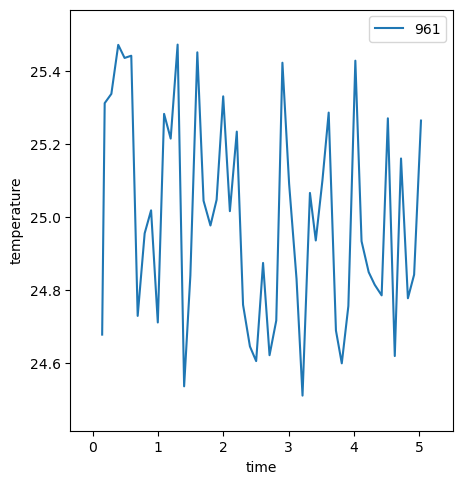

In [8]:
RE(bp.count([temperature], num=50, delay=0.1, md={"motive": "tscan"}))

## Get the data (from the database)
Let's get the measured data from the database now.  It's the most recent bluesky run, so an index of `-1` will identify it.

In [9]:
dataset = cat[-1].primary.read()

Let's get the values as a 1-D numpy array.

In [10]:
T = dataset["temperature"].values

## Compute the statistics
Use the methods of numpy arrays to compute maximum, mean, standard deviation, and minimum.  Looks nicer in a table.

In [11]:
import pyRestTable

table = pyRestTable.Table()
table.addLabel("measure")
table.addLabel("value")
table.addRow(("max", T.max()))
table.addRow(("mean", T.mean()))
table.addRow(("dev", T.std()))
table.addRow(("min", T.min()))
table.addRow(("#", len(T)))
print(table)

======= ==================
measure value             
======= ==================
max     25.471862363622492
mean    24.994794842450602
dev     0.2892339831470962
min     24.50918593118181 
#       50                
======= ==================



Let's replot that data for comparison.

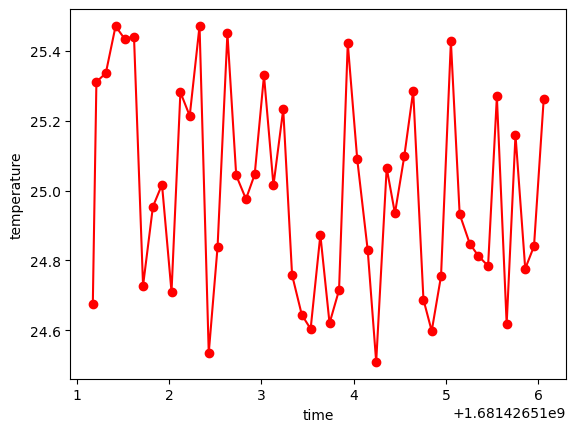

In [12]:
dataset["temperature"].plot(marker="o", color="red")